In [1]:
import os
import sys
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)


from srcs.engdataset import ENGDataset
from constants import *

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import matplotlib
from scipy import stats
import itertools

matplotlib.rcParams.update({'font.size': 6})

plt.rcParams.update({
            "figure.dpi": 150, 'font.size': 10,
            'figure.figsize': (5,3), 'axes.axisbelow': True,
            'axes.edgecolor': COLOR_DICT['clouds'], 'axes.linewidth': 0.4
        })


%load_ext autoreload
%autoreload 2

# Load pickle files with the results_df

In [2]:
DAY_COL = 'day'
SESSION_COL = 'session'
TRIAL_COL = 'rep_id'

BIN_WIDTH_COL = 'bin_width'
K_CV_COL = 'k_cv'
TEMPORAL_COL = 'is_temporal'
N_CHS_COL = 'n_chs'
FEAT_COL = 'feat'
SEED_COL = 'seed'
KERNEL_COL = 'kernel'
FING_COL = 'fing'
FOLD_COL = 'fold'



In [10]:
def parse_params_from_filename(filename):
    params = {}
    day_session = re.search(r'svm_((?:\d+_)*\d+)', filename) .group(1)

    # extract first 2 numbers for day and last 2 for session
    params[DAY_COL] = int(day_session[:2])
    params[SESSION_COL] = day_session[2:4]
    params[SEED_COL] = int(re.search(r'seed_(\d+)', filename).group(1))

    # seach for bin widrh as float
    params[BIN_WIDTH_COL] = float(re.search(r'bin_(\d+\.\d+)', filename).group(1))
    params[TEMPORAL_COL] = bool(re.search(r'temporal', filename))
    params[K_CV_COL] = int(re.search(r'kcv_(\d+)', filename).group(1))
    params[N_CHS_COL] = int(re.search(r'nchs_(\d+)', filename).group(1))
    params[KERNEL_COL] = re.search(r'acc_df_(\w+)_', filename).group(1)
    params[FEAT_COL] = filename.split('_')[4]
    # search for a list of strings in filename
    # params[FING_COL] = [f for f in filename.split('_')[12].strip('[]').split(',')]
    return params

def load_results_to_df(data_directory='data/clf_results'):
    results_dir = os.path.join(project_dir, data_directory)
    compiled_df = pd.DataFrame()

    for filename in os.listdir(results_dir):
        print(filename)
        if 'svm' not in filename:
            continue

        # search for the day, session, trial, bin_width, k_cv, is_temporal, n_chs, feat, seed
        day_session = re.search(r'svm_((?:\d+_)*\d+)', filename) 
        if day_session is None:
            continue

        params = parse_params_from_filename(filename)
        with open(os.path.join(results_dir, filename), 'rb') as f:
            # load to df
            acc_df = pkl.load(f)
        acc_df[DAY_COL] = params[DAY_COL]
        acc_df[SESSION_COL] = params[SESSION_COL]
        acc_df[SEED_COL] = params[SEED_COL]
        acc_df[BIN_WIDTH_COL] = params[BIN_WIDTH_COL]
        acc_df[K_CV_COL] = params[K_CV_COL]
        acc_df[TEMPORAL_COL] = params[TEMPORAL_COL]
        acc_df[N_CHS_COL] = params[N_CHS_COL]
        acc_df[FEAT_COL] = params[FEAT_COL]
        acc_df[KERNEL_COL] = params[KERNEL_COL]
        acc_df[FOLD_COL] = acc_df.index
        # acc_df[FING_COL] = params[FING_COL]
        compiled_df = pd.concat([compiled_df, acc_df], axis=0)

    return compiled_df

        

In [11]:
compiled_df = load_results_to_df(data_directory='data/clf_results/without_removing_channels')

svm_1701_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tridigit. Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.1.pkl
svm_2301_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tridigit. Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.1.pkl
svm_1601_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tridigit. Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.1.pkl


In [12]:
compiled_df.groupby([DAY_COL, SESSION_COL])['acc_val'].count()

day  session
16   01         5
17   01         5
23   01         5
Name: acc_val, dtype: int64

In [15]:
compiled_df.groupby([DAY_COL, SESSION_COL])['acc_val'].mean()

day  session
16   01         0.630263
17   01         0.505263
23   01         0.721053
Name: acc_val, dtype: float64

# Plot metrics across days

## Statistical tests

In [13]:
compiled_df[SESSION_COL].unique()
compiled_df[DAY_COL].unique()
compiled_df[SEED_COL].unique()
# compiled_df[compiled_df[N_CHANNELS]==56]
compiled_df

,acc_train,acc_val,f1_train,f1_val,prec_train,prec_val,recall_train,recall_val,day,session,seed,bin_width,k_cv,is_temporal,n_chs,feat,kernel,fold
0,0.751645,0.513158,0.756081,0.503108,0.757323,0.518147,0.757895,0.513158,17,01,10,0.1,5,True,56,power,linear,0
1,0.764254,0.486842,0.768767,0.476913,0.769758,0.479064,0.770175,0.486842,17,01,10,0.1,5,True,56,power,linear,1
2,0.781250,0.500000,0.781996,0.485408,0.784104,0.501906,0.784211,0.500000,17,01,10,0.1,5,True,56,power,linear,2
3,0.789474,0.539474,0.786988,0.552930,0.786800,0.561982,0.787776,0.548872,17,01,10,0.1,5,True,56,power,linear,3
4,0.792998,0.486842,0.794297,0.521780,0.794583,0.555462,0.794567,0.503759,17,01,10,0.1,5,True,56,power,linear,4
0,0.970395,0.677632,0.973635,0.660445,0.973763,0.683032,0.973684,0.677632,23,01,10,0.1,5,True,56,power,linear,0
1,0.941776,0.934211,0.939842,0.932342,0.939916,0.933515,0.940109,0.932331,23,01,10,0.1,5,True,56,power,linear,1
2,0.951974,0.684211,0.948615,0.714793,0.949207,0.736991,0.949183,0.729323,23,01,10,0.1,5,True,56,power,linear,2
3,0.953947,0.717105,0.954648,0.678150,0.954946,0.766311,0.954628,0.684211,23,01,10,0.1,5,True,56,power,linear,3
4,0.956908,0.592105,0.959937,0.612906,0.960038,0.674326,0.960073,0.624060,23,01,10,0.1,5,True,56,power,linear,4


In [9]:
# Conduct paired t-tests between the different days
days = compiled_df[DAY_COL].unique()
select_seed = 1
select_session= '01'   # session  02 has a single data point
test_on_metric = 'acc_val'

for day in days:    
    # Step 1: Check if data is normally distributed using Shapiro test
    data = compiled_df[(compiled_df[DAY_COL]==day) ]
    _, p_value = stats.shapiro(data[test_on_metric])
    if p_value < 0.05:
        print(f"Data for day {day} is not normally distributed.")

# Step 3: Conduct pairwise comparisons using Wilcoxon signed-rank test if the data is not normally distributed
paired_test_df = pd.DataFrame(columns=['day_i', 'day_j', 'p_value', 'test_performed', 'pair'])
session_df = compiled_df[compiled_df[SESSION_COL]==select_session]
for i, pair in enumerate(itertools.combinations(days, 2)):
    # check is the data is normally distributed for each pair
    _, p1_value = stats.shapiro(session_df[session_df[DAY_COL]==pair[0]][test_on_metric].values)
    _, p2_value = stats.shapiro(session_df[session_df[DAY_COL]==pair[1]][test_on_metric].values)

    # parse model number
    # np.sort(pair)
    day_i_to_j = f"{np.sort(pair)[0]}-{np.sort(pair)[1]}"

    # session_df = session_df[(session_df[DAY_COL]==pair[0]) & (session_df[SEED_COL]==select_seed)]
    if p1_value < 0.05 and p2_value < 0.05:
        _, p_value = stats.ttest_rel(session_df[session_df[DAY_COL]==pair[0]][test_on_metric].values, 
                                    session_df[session_df[DAY_COL]==pair[1]][test_on_metric].values)
        paired_test_df.loc[i,:] = [pair[0],pair[1], p_value, 't-test', day_i_to_j]
    else:
        _, p_value = stats.wilcoxon(session_df[session_df[DAY_COL]==pair[0]][test_on_metric].values, 
                                        session_df[session_df[DAY_COL]==pair[1]][test_on_metric].values,
                                        correction=False)
        paired_test_df.loc[i,:] = [pair[0],pair[1], p_value, 'wilcoxon', day_i_to_j]



In [10]:
session_df

,acc_train,acc_val,f1_train,f1_val,prec_train,prec_val,recall_train,recall_val,day,session,seed,bin_width,k_cv,is_temporal,n_chs,feat,kernel,fold
0,0.730811,0.460526,0.735419,0.445130,0.739059,0.455568,0.736842,0.460526,17,01,700,0.1,5,True,48,power,linear,0
1,0.713816,0.486842,0.721204,0.483854,0.726506,0.492661,0.722807,0.486842,17,01,700,0.1,5,True,48,power,linear,1
2,0.686404,0.592105,0.691855,0.587926,0.692118,0.588101,0.692982,0.592105,17,01,700,0.1,5,True,48,power,linear,2
3,0.731203,0.500000,0.731181,0.468698,0.739277,0.474379,0.735144,0.481203,17,01,700,0.1,5,True,48,power,linear,3
4,0.714521,0.440789,0.716396,0.487829,0.717886,0.515360,0.716469,0.473684,17,01,700,0.1,5,True,48,power,linear,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.872039,0.532895,0.890885,0.520685,0.897385,0.534624,0.894737,0.532895,16,01,860,0.1,5,True,51,power,linear,0
1,0.848684,0.611842,0.855320,0.614507,0.857544,0.646480,0.854809,0.611842,16,01,860,0.1,5,True,51,power,linear,1
2,0.843202,0.631579,0.849697,0.629569,0.851245,0.639660,0.850877,0.646617,16,01,860,0.1,5,True,51,power,linear,2
3,0.853618,0.723684,0.857807,0.770621,0.858483,0.773330,0.857895,0.774436,16,01,860,0.1,5,True,51,power,linear,3


In [11]:
# repeat paired test for the 2 sessions of day 23
session_df = compiled_df[compiled_df[DAY_COL]==23]
paired_test_day23 = pd.DataFrame(columns=['session_i', 'session_j', 'p_value', 'test_performed', 'pair'])
for i, pair in enumerate(itertools.combinations(session_df[SESSION_COL].unique(), 2)):
    # check is the data is normally distributed for each pair
    _, p1_value = stats.shapiro(session_df[session_df[SESSION_COL]==pair[0]][test_on_metric].values)
    _, p2_value = stats.shapiro(session_df[session_df[SESSION_COL]==pair[1]][test_on_metric].values)

    # parse model number
    day_i_to_j = f"{pair[0]}-{pair[1]}"

    if p1_value < 0.05 and p2_value < 0.05:
        _, p_value = stats.ttest_rel(session_df[session_df[SESSION_COL]==pair[0]][test_on_metric].values, 
                                    session_df[session_df[SESSION_COL]==pair[1]][test_on_metric].values)
        paired_test_day23.loc[0,:] = [pair[0],pair[1], p_value, 't-test', day_i_to_j]
    else:
        _, p_value = stats.wilcoxon(session_df[session_df[SESSION_COL]==pair[0]][test_on_metric].values, 
                                        session_df[session_df[SESSION_COL]==pair[1]][test_on_metric].values,
                                        correction=False)
        paired_test_day23.loc[0,:] = [pair[0],pair[1], p_value, 'wilcoxon', day_i_to_j]
paired_test_day23

,session_i,session_j,p_value,test_performed,pair
0,01,02,0.090382,wilcoxon,01-02


In [12]:
paired_test_df

,day_i,day_j,p_value,test_performed,pair
0,17,23,0.0,wilcoxon,17-23
1,17,16,0.0,wilcoxon,16-17
2,23,16,0.000001,wilcoxon,16-23


In [14]:
compiled_df.groupby([DAY_COL, SESSION_COL, N_CHS_COL], as_index=False)['acc_val'].mean()


,day,session,n_chs,acc_val
0,16,01,51,0.643860
1,17,01,48,0.499561
2,23,01,54,0.759539
3,23,02,55,0.731908


Single session:
0    64.39
1    49.96
2    75.95
Name: acc_val, dtype: float64
17(17) - 16 (16): 1.4317355746533414e-10 rounded 0.0
17(17) - 23 (23): 2.2028969790040626e-11 rounded 0.0
23(23) - 16 (16): 9.96565304841372e-07 rounded 0.0


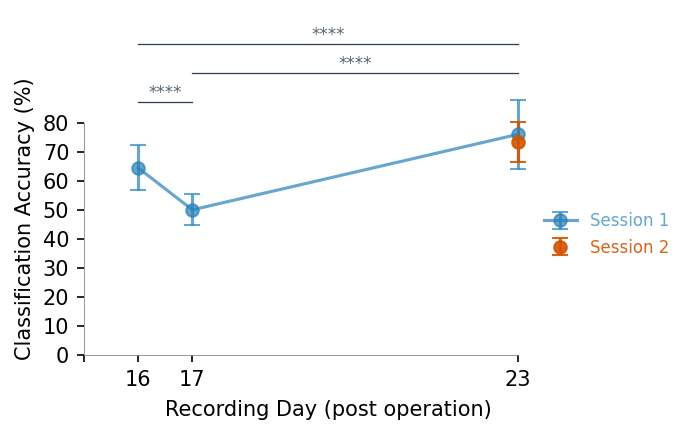

In [15]:
# compute mean and sd across folds
metrics_list = ['acc', 'prec', 'f1', 'recall']
metrics_datasets = [
    f'{metric}_{dataset}' for metric in metrics_list for dataset in ['train', 'val']]
mean_metrics = compiled_df.groupby([DAY_COL, SESSION_COL, BIN_WIDTH_COL, K_CV_COL,
                                   TEMPORAL_COL, N_CHS_COL, FEAT_COL, KERNEL_COL], as_index=False).mean()
sd_metrics = compiled_df.groupby([DAY_COL, SESSION_COL, BIN_WIDTH_COL, K_CV_COL,
                                 TEMPORAL_COL, N_CHS_COL, FEAT_COL, KERNEL_COL], as_index=False).std()

# plot mean and sd per day
fig, ax = plt.subplots(figsize=(4, 3))

# fig = plt.figure(figsize=(4, 5))
# ax = fig.add_subplot(211)

# ax_count = fig.add_subplot(212)
p_val_order =  ["16-17", "17-23", "16-23"]
sort_p_by = 'day_i'

pval_y = 87
yshift = 10

# plot the number of channels on the twin axis
# ax_count.bar(mean_metrics[DAY_COL], mean_metrics[N_CHS_COL], 
#               color=COLOR_DICT['midnight_blue'], label='Number of channels', alpha=0.7)
# ax_count.set_ylabel('Number of channels', labelpad=YLAB_PAD)
# ax_count.set_ylim([0, 56])

for metric in ['acc_val']:
    mean_metrics[metric] = mean_metrics[metric].round(4) *100
    sd_metrics[metric] = sd_metrics[metric].round(4) *100

    single_sess_mu = mean_metrics[mean_metrics[SESSION_COL] == '01']
    single_sess_sd = sd_metrics[sd_metrics[SESSION_COL] == '01']
 
    double_sess_mu = mean_metrics[mean_metrics[SESSION_COL] == '02']
    double_sess_sd = sd_metrics[sd_metrics[SESSION_COL] == '02']
    
    print(f"Single session:\n{single_sess_mu[metric]}")
    ax.errorbar(single_sess_mu[DAY_COL], single_sess_mu[metric], single_sess_sd[metric],alpha=0.7,
                capsize=4, color=COLOR_DICT['belize'], fmt='-o', label='Session 1')
    

    ax.errorbar(double_sess_mu[DAY_COL], double_sess_mu[metric], double_sess_sd[metric],alpha=0.9, 
                capsize=4, color=COLOR_DICT['pumpkin'], fmt='o', label='Session 2')
    
    # get the avergage metric per seed (average across folds)
    seed_mean_metric = compiled_df.groupby([DAY_COL, SESSION_COL, SEED_COL], as_index=False)[metric].mean()
    seed_mean_metric[metric] = seed_mean_metric[metric] * 100

    # ax.scatter(seed_mean_metric[seed_mean_metric[SESSION_COL]=='01'][DAY_COL], 
    #             seed_mean_metric[seed_mean_metric[SESSION_COL]=='01'][metric], color=COLOR_DICT['midnight_blue'], 
    #             s=3,
    #             alpha=1)
    
    # Add statistical annotation
    day_order = [16,17,23]
    paired_test_df = paired_test_df.sort_values(sort_p_by)

    for pair in p_val_order:
        row = paired_test_df[paired_test_df['pair']==pair].iloc[0]
        x1 = day_order[np.where(np.array(day_order) == row['day_i'])[0][0]]
        x2 = day_order[np.where(np.array(day_order) == row['day_j'])[0][0]]
        p_value = np.round(row['p_value'],4)
        print(f"{x1}({ row['day_i']}) - {x2} ({row['day_j']}): {row['p_value']} rounded {p_value}")

        if p_value < 0.05:
            if p_value < 1e-4:   # for p < 1e-05
                p_text = "****"
            
            elif p_value < 1e-3: # for p < 0.001
                p_text = "***"

            elif p_value < 1e-2:  # for p < 0.01
                p_text = "**"

            else:
                p_text = f"p={p_value}"

            h, col =  0, COLOR_DICT['midnight_blue']
            ax.plot([x1, x1, x2, x2], [pval_y, pval_y +h,  pval_y +h, pval_y], lw=0.6, c=col)
            ax.text((x1+x2)*.5, pval_y+h, f'{p_text}', ha='center', va='bottom', color=col,
                    alpha=0.8, fontdict={'fontsize':8})
            pval_y += yshift 

    ax.set_ylabel(f'Classification Accuracy (%)', labelpad=YLAB_PAD)
    ax.yaxis.set_label_coords(-0.1, 0.4)

    ax.set_xlabel('Recording Day (post operation)', labelpad=XLAB_PAD)
    ax.set_xticks([15,16,17,23], labels = [ '',16, 17, 23])

    ax.set_ylim([0,pval_y])
    ax.set_xlim([15,24])
    ax.set_yticks(np.arange(0, 85, 10))
    sns.despine(ax=ax, offset=0, trim=True)



fig.tight_layout()
fig.legend(loc='lower right', ncol=1, frameon=False, labelcolor='linecolor', fontsize=8,
              bbox_to_anchor=(1.15, 0.38))
# save figure
fig.savefig( f'figures/svm_acc_day_session_across_seeds.png', bbox_inches='tight')

In [16]:
# average across seeds
mean_metrics[[DAY_COL,SEED_COL,SESSION_COL, N_CHS_COL, 'acc_train','acc_val']]

,day,seed,session,n_chs,acc_train,acc_val
0,16,275.833333,01,51,0.849885,64.39
1,17,275.833333,01,48,0.710424,49.96
2,23,275.833333,01,54,0.982489,75.95
3,23,275.833333,02,55,0.932977,73.19


In [17]:
# sd across seeds
sd_metrics[[DAY_COL,SEED_COL,SESSION_COL, N_CHS_COL, 'acc_train','acc_val']]

,day,seed,session,n_chs,acc_train,acc_val
0,16,290.752336,01,51,0.021392,7.74
1,17,290.752336,01,48,0.017243,5.29
2,23,290.752336,01,54,0.007739,11.81
3,23,290.752336,02,55,0.012688,6.86


# Comparison bar plots with SNN (diagonal of confusion matrix)

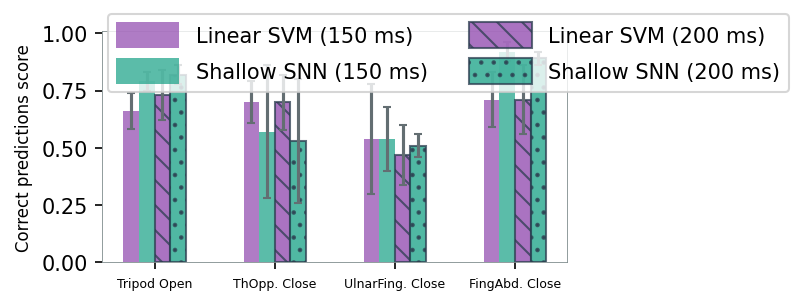

In [25]:
# Comparison plot in Appendix
svm_mean_150 = [0.66, 0.7, 0.54,0.71]            #100 ms,50% [0.62, 0.65, 0.51, 0.72]
svm_std_150 =  [0.08, 0.09, 0.24, 0.12]          #100 ms, 50%[0.07, 0.08, 0.17, 0.08]
svm_mean_200 = [0.73, 0.7 , 0.47 ,0.71]          # 200 ms time bins
svm_std_200 = [0.11, 0.12 ,0.13 ,0.15]

snn_mean_150 = [0.79, 0.57, 0.54, 0.92]          #100 ms,50%  [0.82, 0.53, 0.51, 0.89]
snn_std_150=  [0.04, 0.29, 0.14, 0.04]          #100 ms,50% [0.04, 0.27, 0.05, 0.03]

snn_mean_200 = [0.82, 0.53, 0.51, 0.89]          # 200 ms time bins
snn_std_200 = [0.04,0.27, 0.05, 0.03]

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
bwidth =0.13


ax.bar(np.arange(4), svm_mean_150, width=bwidth, yerr=svm_std_150, capsize=2, 
        label='Linear SVM (150 ms)', ecolor='#636e72', alpha=0.7, color= COLOR_DICT['wisteria'])
ax.bar(np.arange(4)+bwidth, snn_mean_150, width=bwidth, yerr=snn_std_150, capsize=2, 
       label='Shallow SNN (150 ms)', 
       ecolor='#636e72',  color=COLOR_DICT['green_sea'], alpha=0.7)


ax.bar(np.arange(4)+ 2*bwidth, svm_mean_200, width=bwidth, yerr=svm_std_200, capsize=2, 
        label='Linear SVM (200 ms)', ecolor='#636e72', alpha=0.75, color= COLOR_DICT['wisteria'],
        hatch='\\\\', edgecolor=COLOR_DICT['midnight_blue'])
ax.bar(np.arange(4)+3* bwidth, snn_mean_200, width=bwidth, yerr=snn_std_200, capsize=2, 
       label='Shallow SNN (200 ms)',edgecolor=COLOR_DICT['midnight_blue'],
       ecolor='#636e72',  color=COLOR_DICT['green_sea'], alpha=0.75,

       hatch="..")

# ax.legend(handles=[circ1,circ2], loc='upper left', ncol=2, bbox_to_anchor=(-0.01, 1.22),handleheight=2, handlelength=4)
ax.set_xticks(np.arange(1.5*bwidth,4+1.5*bwidth,1 ), CLASS_TO_GEST.values(), fontsize=6)
plt.ylabel('Correct predictions score', fontsize=8)
plt.legend(loc='upper left', ncol=2, bbox_to_anchor=(-0.01, 1.12),handleheight=1.5, handlelength=3)
plt.show()

# save figure

# fig.savefig(os.path.join(CLF_FIG, f'day{DAY}{SESSION}_svm_vs_snn_150ms_200ms_50_overlap_wider.png'), dpi=300, bbox_inches='tight')

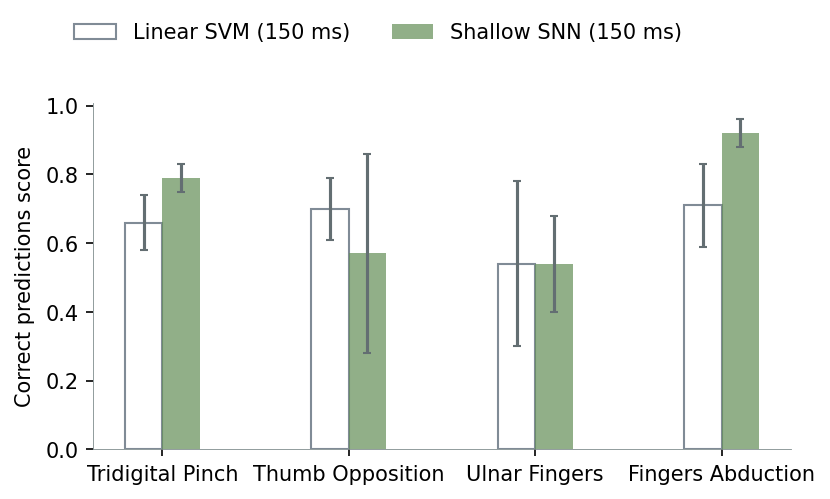

In [26]:
plot_results_for_win = 150  # ms with 50% overlap

if plot_results_for_win == 150:
        # For 150 ms with 50% overlap
        svm_mean = [0.66, 0.7, 0.54,0.71]            #for 100 ms,50%:  [0.62, 0.65, 0.51, 0.72]
        svm_std =  [0.08, 0.09, 0.24, 0.12]          #for 100 ms, 50%: [0.07, 0.08, 0.17, 0.08]

        snn_mean = [0.79, 0.57, 0.54, 0.92]          #for 100 ms,50%:  [0.82, 0.53, 0.51, 0.89]
        snn_std =  [0.04, 0.29, 0.14, 0.04]          #for 100 ms,50%:  [0.04, 0.27, 0.05, 0.03]
if plot_results_for_win == 100:
        # For 100 ms with 50% overlap
        svm_mean = [0.62, 0.65, 0.51, 0.72]
        svm_std = [0.07, 0.08, 0.17, 0.08]

        snn_mean = [0.82, 0.53, 0.51, 0.89]
        snn_std = [0.04, 0.27, 0.05, 0.03]

# figure styling
svm_color = 'white' #COLOR_DICT['midnight_blue']
svm_edge = COLOR_DICT['midnight_blue']

snn_color = '#628D56' #'white'
snn_hatch = None#'//'
snn_edge = None #COLOR_DICT['midnight_blue']

fig = plt.figure(figsize=(6,3))

ax = fig.add_subplot(111)
bwidth = 0.2
ax.bar(np.arange(4), svm_mean, width=bwidth, yerr=svm_std, capsize=2, 
        label=f'Linear SVM ({plot_results_for_win} ms)', ecolor='#636e72',  alpha=0.6, color= svm_color,
        edgecolor=svm_edge
        )

ax.bar(np.arange(4)+bwidth, snn_mean, width=bwidth, yerr=snn_std, capsize=2, label=f'Shallow SNN ({plot_results_for_win} ms)',
       edgecolor=snn_edge, hatch=snn_hatch,
       ecolor='#636e72',  color=snn_color, alpha=0.7)

ax.set_xticks(np.arange(bwidth/2, 4+bwidth/2, 1))
ax.set_xticklabels(['Tridigital Pinch', 'Thumb Opposition', 'Ulnar Fingers', 'Fingers Abduction'], rotation=45)
ax.set_ylabel('Correct predictions score', labelpad=YLAB_PAD)
# plt.show()
sns.despine(ax=ax, offset=0, trim=False)

fig.legend( ncol=2, frameon=False, bbox_to_anchor=(0.8, 1.1))
#save figure
fig.savefig(os.path.join(CLF_FIG, f'day{DAY}{SESSION}_svm_vs_snn_{plot_results_for_win}ms_50_overlap.png'), dpi=300, bbox_inches='tight')

In [23]:
print(f"Mean across gestures:\nSVM: {np.mean(svm_mean)*100} +- {np.mean(svm_std)*100}")

print(f"SNN: {np.mean(snn_mean)*100} +- {np.mean(snn_std)*100}")


Mean across gestures:
SVM: 62.5 +- 10.000000000000002
SNN: 68.75 +- 9.75
